<a href="https://colab.research.google.com/github/xvh422/L4-Project/blob/main/Mass%20Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install eagleSqlTools
!pip install colossus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 7.5 MB/s 


In [2]:
import eagleSqlTools as sql
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable
from colossus.cosmology import cosmology
from colossus.lss import mass_function

con = sql.connect("vwg533", password = "FZtn087h")

In [5]:
cosmology.setCosmology('WMAP9')
# mfunc_fof = mass_function.massFunction(1E12, 0.0, mdef = 'fof', model = 'watson13')

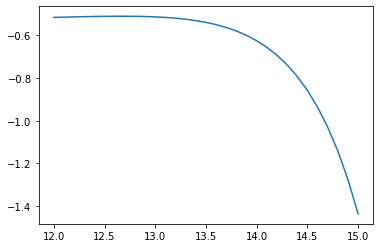

In [40]:
powers = np.arange(12,15.1, 0.1)
masses = 10**powers
mfunc = []

for i in range (len(masses)):
  mfunc = mfunc + [mass_function.massFunction(masses[i], 0.0, mdef = 'fof', model = 'watson13')]# mdef = 'vir', model = 'tinker08')]

plt.figure()

plt.plot(np.log10(masses), np.log10(mfunc))

plt.show()

In [16]:
sim_name = 'RefL0100N1504'
sim_size = 100.

Query = "SELECT \
          FOF.Group_M_Crit200 as m200, \
          SH.MassType_Star as star \
        FROM \
          %s_FOF as FOF, \
          %s_SubHalo as SH \
        WHERE \
          SH.SnapNum = 28 and \
          SH.SubGroupNumber = 0 and \
          SH.MassType_Star > 0 and \
          FOF.Group_M_Crit200 > 1e12 and \
          SH.GroupID = FOF.GroupID" %(sim_name, sim_name)

Results = sql.execute_query(con, Query)

In [34]:
#Replaces zeroes with the smallest nonzero value.
def log_with_zeros(data):
  logs = np.empty(len(data))
  for i in range(0, len(data)):
    if data[i] == 0.0:
      logs[i] = 99.
    else:
      logs[i] = np.log10(data[i])
  m = logs.min()
  for j in range(0, len(logs)):
    if logs[j] == 99.:
      logs[j] = m
    else:
      logs[j] = logs[j]
  return logs

In [35]:
log_mh = np.log10(Results['m200'])
binned_masses = {}

step = 0.1
bins = np.arange(12, 15.1, step)

for bin in bins:
  masses = log_mh[np.logical_and(log_mh > bin, log_mh < bin+step)]
  binned_masses[bin] = masses

In [36]:
sim_volume = sim_size**3
galaxy_counts = np.empty(len(bins))

for i in range(len(bins)):
  galaxy_counts[i] = len(binned_masses[bins[i]])

galaxy_densities = galaxy_counts/sim_volume

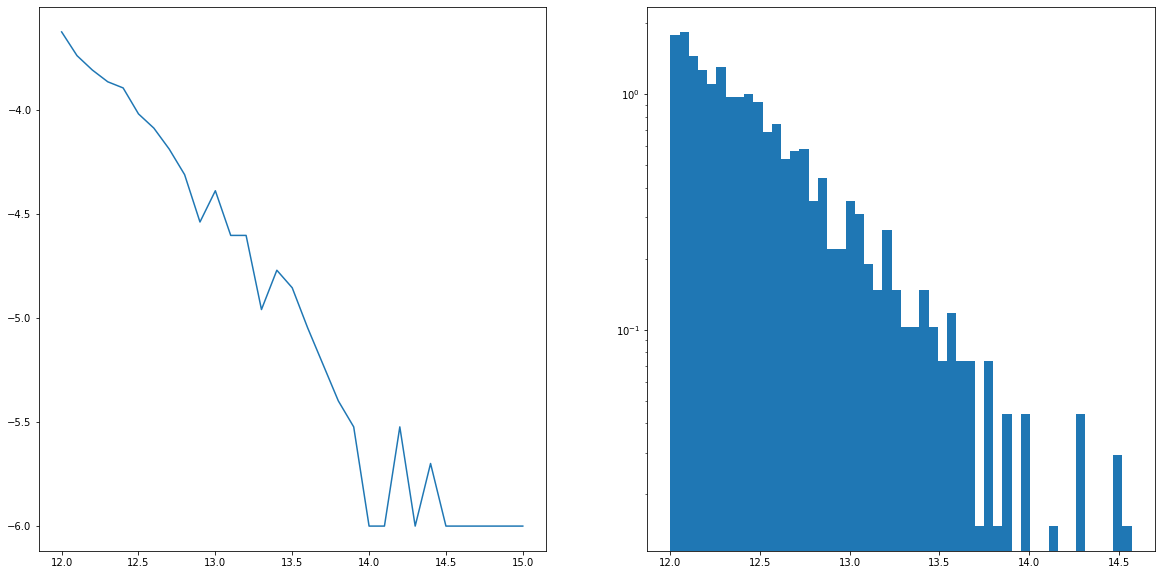

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))

ax1.plot(bins, log_with_zeros(galaxy_densities))
ax2.hist(np.log10(Results['m200']), bins = 50, log=True, density=True)

plt.show()